# Probability Threshold Moving

Many machine learning algorithms are capable of predicting a probability or scoring of class membership, and this must be interpreted before it can be mapped to a crisp class label.  This isachieved by using a threshold, such as 0.5, where all values equal or greater than the thresholdare mapped to one class and all other values are mapped to another class.

For those classification problems that have a severe class imbalance, the default thresholdcan result in poor performance.  As such, a simple and straightforward approach to improvingthe performance of a classifier that predicts probabilities on an imbalanced classification problemis to tune the threshold used to map probabilities to class labels.

In some cases, such as when using ROC Curves and Precision-Recall Curves, the best oroptimal threshold for the classifier can be calculated directly.  In other cases, it is possible touse a grid search to tune the threshold and locate the optimal value.  In this tutorial, you willdiscover how to tune the optimal threshold when converting probabilities to crisp class labelsfor imbalanced classification.


  After completing this tutorial, you will know:
 - The default threshold for interpreting probabilities to class labels is 0.5, and tuning this hyperparameter is called threshold moving.
 - How to calculate the optimal threshold for the ROC Curve and Precision-Recall Curvedirectly.
 - How to manually search threshold values for a chosen model and model evaluation metric
 
 This tutorial is divided into five parts; they are:1.  
 
1. Converting Probabilities to Class Labels
2.  Threshold-Moving for Imbalanced Classification
3.  Optimal Threshold for ROC Curve
4.  Optimal Threshold for Precision-Recall Curve
5.  Optimal Threshold Tuning

## Converting Probabilities to Class Labels

 The decision for converting a predicted probability or scoring into a class label is governed by a parameter referred to as the decision threshold,discrimination threshold, or simply the threshold.  The default value for the threshold is 0.5 for normalized predicted probabilities or scores in the range between 0 or 1.
 
 ...   almost  all  classifiers  generate  positive  or  negative  predictions  by  applying  a threshold  to  a  score.   The  choice  of  this  threshold  will  have  an  impact  in  thetrade-offs of positive and negative errors. *Page 53,Learning from Imbalanced Data Sets, 2018.*
 
 The problem is that the default threshold may not represent an optimal interpretation of the predicted probabilities.  This might be the case for a number of reasons, such as:
 
- The predicted probabilities are not calibrated, e.g.  those predicted by an SVM or decision tree.
- The metric used to train the model is different from the metric used to evaluate a final model.
- The class distribution is severely skewed.
- The cost of one type of misclassification is more important than another type of misclassification.

## Threshold-Moving for Imbalanced Classification

The bottom line is that when studying problems with imbalanced data, using the classifiers produced by standard machine learning algorithms without adjusting the output threshold may well be a critical mistake.*—Machine Learning from Imbalanced Data Sets 101, 2000.*

here are many reasons to choose an alternative to the default decision threshold.  For example, you may use ROC curves to analyze the predicted probabilities of a model and ROCAUC scores to compare and select a model, although you require crisp class labels from your model.  How do you choose the threshold on the ROC Curve that results in the best balance between the true positive rate and the false positive rate?

Alternately, you may use precision-recall curves to analyze the predicted probabilities of a model, precision-recall AUC to compare and select models, and require crisp class labels as predictions.  How do you choose the threshold on the Precision-Recall Curve that results in the best balance between precision and recall?  

You may use a probability-based metric to train, evaluate, and compare models like log loss (cross-entropy) but require crisp class labels to be predicted.  How do you choose the optimal threshold from predicted probabilities more generally?

Finally,  you  may  have  different  costs  associated  with  false  positive  and  false  negative misclassification, a so-called cost matrix, but wish to use and evaluate cost-insensitive models and later evaluate their predictions use a cost-sensitive measure. How do you choose a threshold that finds the best trade-off for predictions using the cost matrix?


Popular way of training a cost-sensitive classifier without a known cost matrix is to put emphasis on modifying the classification outputs when predictions are being made on new data.  This is usually done by setting a threshold on the positive class, below which the negative one is being predicted.  The value of this threshold is optimized using a validation set and thus the cost matrix can be learned from training data. *— Page 67,Learning from Imbalanced Data Sets, 2018.*


The process involves first fitting the model on a training dataset and making predictions on a test dataset.  The predictions are in the form of normalized probabilities, or scores thatare transformed into normalized probabilities.  Different threshold values are then tried and the resulting crisp labels are evaluated using a chosen evaluation metric.  The threshold that achieves the best evaluation metric is then adopted for the model when making predictions on new data in the future.  We can summarize this procedure below.

1.  Fit Model on the Training Dataset.
2.  Predict Probabilities on the Test Dataset.
3.  For each threshold in Thresholds:
        a. Convert probabilities to Class Labels using the threshold.
        b. Evaluate Class Labels.
        c. If Score is Better than Best Score.
            - Adopt Threshold.
4.  Use Adopted Threshold When Making Class Predictions on New Data.

##  Optimal Threshold for ROC Curve

A ROC curve is a diagnostic plot that evaluates a set of probability predictions made by amodel on a test dataset.  A set of different thresholds are used to interpret the true positive rateand the false positive rate of the predictions on the positive (minority) class, and the scores areplotted in a line of increasing thresholds to create a curve.  The false-positive rate is plotted onthe x-axis and the true positive rate is plotted on the y-axis and the plot is referred to as theReceiver Operating Characteristic curve, or ROC curve.  A diagonal line on the plot from thebottom-left to top-right indicates thecurvefor a no-skill classifier (predicts the majority classin all cases), and a point in the top left of the plot indicates a model with perfect skill.The curve is useful to understand the trade-off in the true-positive rate and false-positiverate for different thresholds.  The area under the ROC Curve, so-called ROC AUC, providesa single number to summarize the performance of a model in terms of its ROC Curve with avalue between 0.5 (no-skill) and 1.0 (perfect skill).  The ROC Curve is a useful diagnostic toolfor understanding the trade-off for different thresholds and the ROC AUC provides a usefulnumber for comparing models based on their general capabilities

Thankfully, there are principled ways of locating this point.  First, let’s fit a model andcalculate a ROC Curve. 

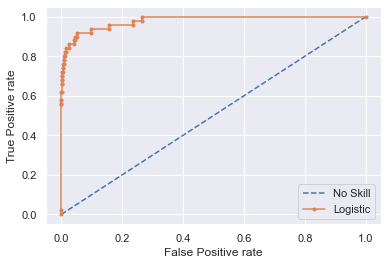

In [27]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
import seaborn as sns
sns.set()

# generate dataset
X, y = make_classification(n_samples=10_000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0,
                           random_state=4)

# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=2, stratify=y)

model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)
yhat = model.predict_proba(X_test)  # predict prob
yhat = yhat[:, 1]  # pos prob only
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=yhat)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.xlabel('False Positive rate')
pyplot.ylabel('True Positive rate')
pyplot.legend();

Running the example fits a logistic regression model on the training dataset then evaluates it using a range of thresholds on the test set, creating the ROC Curve.  We can see that there are a number of points or thresholds close to the top-left of the plot.  Which is the threshold that is optimal?

### from pag 251 in book